In [2]:
import numpy as np
from qutip import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

D:\Code\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Ntrunc = 4 #global operator for truncation level or total number of dimensions

In [3]:
#Hamiltonian for a set of transmons coupled to a mode
class tmon_system:
    def __init__(self,N, Nlevel, E_C, E_j, g_arr, omega):
        self.N = N #value of n goes from 0 to N-1
        self.Nlevel = Nlevel #cut off dimension/truncation
        #This is different from d which is the level that comes into hamiltonian.
        #d refers to the highest excitation present in the initialised state
        #d  by default is set to (Nlevel-2) as (d+1) at max can be (Nlevel-1)
        self.d = Nlevel-2
        self.E_c= E_c
        self.E_j = E_j
        self.g_arr = g_arr #g^n_i = g_arr[n][i]
        self.omega = omega #freq of photonic mode
        self.v_arr = self.freq_list() #v[n][i] = v^n_i
    
    def freq_list(self):
        #calculate v^n_i
        #for |i><i|_n, coefficient is  \sqrt(8E^n_j*E^n_c)*i - E^n_c/2*i(i+1)
        arr = []
        for n in range(self.N):
            temp_arr = []
            for i in range(self.d+1):
                v_ni = np.sqrt(8*self.E_c[n]*self.E_j[n])*i - 0.5*self.E_c[n]*i*(i+1)
                temp_arr.append(v_ni)
            arr.append(temp_arr) 
        return arr
    
    def cal_delta(self):
        #simplest version is to equate to average over transmons i.e n
        delta_arr = []
        
        for n in range(self.N):
            temp = 0
            for i in range(self.d +1):
                temp = temp + ((self.g_arr[n][i]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]-self.omega)+self.v_arr[n][i])
            delta_arr.append(temp/(self.d+1))
        return delta_arr
    
    def tensor_id(self, dim = None):
        if dim ==None:
            dim = self.d+2
        #IxIxIxI...Ioperator
        Neye = []
        for i in  range(self.N):
            Neye.append(qeye(dim))
        nid = tensor(Neye)
        return nid
          
    def tensor_projection_op(self,n,i,j, dim = None):
        #returns IxIxIx...(|i><j|_n)xIxI...xI
        if n > self.N-1:
            print("invalid n")
            return
        if dim ==None:
            dim = self.d+2
            
        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(dim))
        #(|i><j|_n)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def H_I(self, delta_arr = None):
        #rotataed time indp effective hamiltonian
        #lambda_arr contains \Delta_i to be added as self energy corrections
        if delta_arr==None:
            delta_arr = self.cal_delta()
        
        H0 = 0
        for n in range(self.N):
            for i in range(self.d + 1):
                c_ni = (self.g_arr[n][i-1]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]- self.omega) + self.v_arr[n][i] - delta_arr[i]
                H0 = H0 + c_ni*self.tensor_projection_op(n,i,i)
        
        H1 = 0
        for n in range(self.N):
            for m in range(self.N):
                for i in range(self.d + 1):
                    if n == m:
                        break
                    c_nmi = 0.5*(self.g_arr[n][i]*self.g_arr[m][i])/(self.omega - self.v_arr[m][i])
                    H1 = H1 + c_nmi*(self.tensor_projection_op(n,i,i+1)*self.tensor_projection_op(m,i+1,i) + self.tensor_projection_op(n,i+1,i)*self.tensor_projection_op(m,i,i+1))
        
        return H0 + H1

def generate_tmon_arch(N,Nlevel):
    #scaling is 1 to 100MHz
    E_j =  np.absolute(np.random.normal(200,20, N))
    E_c = np.absolute(np.random.normal(2.5,0.2, N))
    g_arr = np.zeros((N,Nlevel))
    for n in range(N):
        for i in range(Nlevel):
            g_arr[n][i] = 1
    omega = 2
    return E_j, E_c, g_arr,omega 

In [ ]:
#entire process involves 3 steps
## 1) Evolution by H
## 2) Encoding \theta by applying U = e^{iJ\theta}
## 3) Measurement using some projections

In [4]:
#initialize system
N = 3
Nlevel = Ntrunc
E_j, E_c, g_arr, omega = generate_tmon_arch(N,Nlevel)
sys1 = tmon_system(N, Nlevel, E_c, E_j, g_arr, omega)

In [5]:
#Evolution of a particular \rho with H' and \t
#simply solve the U\rhoU' for different thetas
H = sys1.H_I()
psi0 = sys1.tensor_projection_op(0,1,1, dim = None)
psi0 = psi0 / psi0.norm() #normalize vector
times = np.linspace(0,1,10)
options = Options()
options.store_final_state = True
result = mesolve(H, psi0, times, [], options = options)

In [6]:
#Encode \theta by applying U = e^{i n.J \theta}
psi_i = results.states[-1] #final state of time evolution
n = basis(3,1)
J_arr = np.array([]) #generators or their subset
theta_arr = np.linspace(0, 0.5, 2) #values of theta to encode
#code for n.J
result2 = mesolve(n*J_arr, psi0, times, [], options = options)


10

In [ ]:
psi_f = results2.states[-1] #any state can be taken as all are valid encodings

#Calculation of covariance matrix
#FI = n^T C n
C = np.zeros((3,3))#3x3 matrix for 3 generators of spin 1/2
for i in range(3):
    for j in range(3):
        C[i][j] = 0.5*((rho_i*J_arr[i]*J_arr[j]).tr()+ (rho_i*J_arr[j]*J_arr[i]).tr())- (rho_i*J_arr[i]).tr()*(rho_i*J_arr[j]).tr()

#when n is the eigenvector with maximum eigen value of C, FI is maximized
# Define the matrix
matrix = C
# Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(matrix)
# Find the index of the maximal eigenvalue
max_index = np.argmax(eigenvalues)
# Get the maximal eigenvalue and the corresponding eigenvector
max_eigenvalue = eigenvalues[max_index]
max_eigenvector = eigenvectors[:, max_index]

#Plot FI_max vs time/\theta
FI_max = 4*max_eigenvalue

In [7]:
#Fisher Info Calculation
def purestate_FI(J,psi):
    FI = 4*variance(J,psi)
    return FI

Text(0, 0.5, 'Finsher Info')

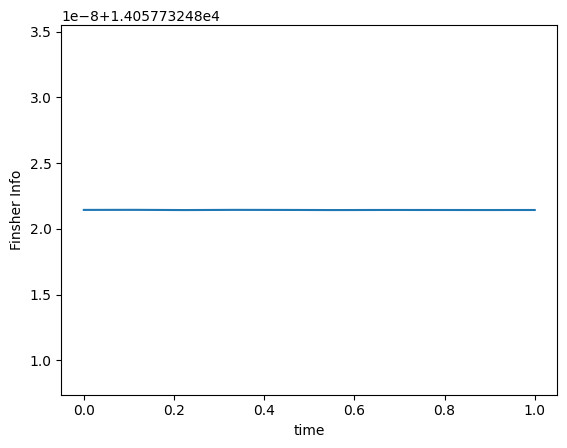

In [8]:
FI_list = []
for psi in result.states:
    FI_list.append(purestate_FI(H,psi))

plt.plot(times,FI_list)
plt.xlabel("time")
plt.ylabel("Finsher Info")

In [ ]:
#pauli operators for the tmon system
#here we have taken spin1 
jx = jmat(1, 'x')
jy = jmat(1, 'y')
jz = jmat(1, 'z')
#padded operators
Nlevel = Ntrunc
spin = 1
dim = spin*2+1
jx = np.identity(Ntrunc, dtype=complex)
jy = np.identity(Ntrunc, dtype=complex)
jz = np.identity(Ntrunc, dtype=complex)
jx[0:dim, 0:dim] = jmat(spin,'x').full()
jy[0:dim, 0:dim] = jmat(spin,'y').full()
jz[0:dim, 0:dim] = jmat(spin,'z').full()

#combined spin operators
N = 3 #number of transmons
def ensemble_op(op,n,N):
    #returns IxIxIx...(op_n)xIxI...xI
    if n > N-1:
        print("invalid n")
        return

    Neye = []
    for k in  range(N):
        Neye.append(qeye(op.shape[0]))
    #(op_n)
    Neye[n] = Qobj(op)
    nid = tensor(Neye)
    return nid

JX = 0
JY = 0
JZ = 0
for i in range(N):
    JX = ensemble_op(jx,i,N)
    JY = ensemble_op(jx,i,N)
    JZ = ensemble_op(jx,i,N)

In [ ]:
#create spin operators
class operators:
    def __init__(self, N, spin):
        self.N = N
        self.spin =spin
        
    
    def generators_arr(self):
        #return all generators for a spin-n algebra
        return
    
    def tensor_operator(self,op,i):
        #returns IxIxIx...(op_i)xIxI...xI
        if i > self.N-1:
            raise ValueError("index needs to be between 0 and"+str(self.N)+"-1")

        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(self.spin))
        #(op_i)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def J_n(self,n):
        #\sum (n.J)_i
        #it should take both 3x1 and dx1 vectors
        #3x1 leads to use of just sigma x,y,z
        #dx1 leads to use of all generators
        jx = jmat(i, 'x')
        jy = jmat(i, 'y')
        jz = jmat(i, 'z')
        
        
     
    def nonlin_operators(self, degree):
        #take array of generators and combine them to get non-lin operators
        #return vector with non-lin operators only
        lin_op_arr = self.generators_arr
        nonlin_arr = []

In [ ]:
#calculate optimal squeezing parameter
H_cap = [] #array of all operators being considered
##calculate covariance matrix
##calculate commutator matrix
def calculate_covariance(matrix1, matrix2):
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Calculate the covariance
    covariance = np.cov(matrix1, matrix2, bias=True)
    
    return covariance

def covariance_matrix(H_cap):
    tau = np.zeros((len(H_cap),len(H_cap)))
    for k in range(len(H_cap)):
        for l in range(len(H_cap)):
            tau[k][l] = calculate_covariance(H_cap[k],H_cap(l))